__author__      = "Yibo HU"

Last_updated: 12/21/2020

This is a jupyter notebook of the annotation pipeline
modified from 

https://github.com/the-knightfury/SATP-Event-Classification-V1/tree/master/SourceCode

Thanks to Shahreen


For new updates in annotations, simply import the libraries below and run step 5 only.

In [1]:
# -*- coding: utf-8 -*-
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import sklearn
import time

# 1. crawler_terrorism_articles_tags

In [ ]:
months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
countries = ["bangladesh", "india", "pakistan", "bhutan", "nepal", "maldives", "afghanistan", "srilanka"]
years = ["2019", "2018", "2017", "2016", "2015", "2014", "2013", "2012", "2011", "2010"]

# Saving News Content and The Country wise location in these 2 lists
news_contents = []
news_location = []

for i in years:
    print("year:", i)
    # Iterating over each country
    for k in countries:
        # Iterating over each month
        print("\tcountry:", k)
        for j in months:
            print('\t\tmonths:', j)

            url = "https://www.satp.org/terrorist-activity/"+ k + "-" + j + "-" + i

            # Request
            r1 = requests.get(url)

            # We'll save in coverpage the cover page content
            coverpage = r1.content

            # Soup creation
            soup1 = BeautifulSoup(coverpage, 'html.parser')

            # News identification
            coverpage_news = soup1.find_all('div', class_='more')

            news_size = len(coverpage_news)

            for paragraph_num in range(news_size):
                paragraph = coverpage_news[paragraph_num].get_text()
                paragraph = re.sub("^\s+|\s+$", "", paragraph, flags=re.UNICODE)
                paragraph = " ".join(re.split("\s+", paragraph, flags=re.UNICODE)[:-2])
                news_location.append(k)
                news_contents.append(paragraph)

        print("\tcountry:", k, ' ' ,len(news_contents))

news_data = pd.DataFrame({'location': news_location,
                          'news': news_contents})

print(news_data.shape)

# news_data.to_csv ('./Satp_Data/news_satp_2010.csv', index = False, header=True)

# 2. process_data_for_annotation

In [2]:
def remove_special_characters(data, col_name):
    spec_chars = ["!", '"', "#", "%", "&", "'", "*", "+", "-", "/", ":", ";", "<", "=",
                  ">", "?", "@", "[", "\\", "]", "^", "_", "`", "{", "|", "}", "~", "–"]
    for char in spec_chars:
        data[col_name] = data[col_name].str.replace(char, ' ')
    data[col_name] = data[col_name].str.split().str.join(" ")
    return data

def probable_relevant_story(news, event_set, threshold):
    tokenized = news.split(" ")
    count = 0
    for t in tokenized:
        if t in event_set:
            count += 1
        if count >= threshold:
            return True
    return False

In [3]:
master_data_path = 'RawSATPData/master_2011To2015.csv'
master_data = pd.read_csv(master_data_path, header=[0])  
master_data = remove_special_characters(master_data, 'news')

In [4]:
action_path = "Data_Events/action.csv" 
actions = pd.read_csv(action_path, header=None)   #  Here header should be None instead of [0] in the previous version
actions_set = set(actions.iloc[:,0])
len(actions_set)

193

## Assume a threshold = 4 to select samples 

In [9]:
# Step - 1 : Pull Out All the Probable relevant story
master_data['Relevance'] = master_data['news'].apply(probable_relevant_story, args = (actions_set, 4))
print(master_data[master_data['Relevance'] == True].shape)

(21902, 5)


## save master data

In [5]:
master_data

,year,month,location,news
0,2015,1,bangladesh,"On January 1, in Jhenidah, Police arrested nin..."
1,2015,1,bangladesh,"Police recovered a 7.6mm foreign pistol, a pip..."
2,2015,1,bangladesh,The prosecution on January 1 filed a petition ...
3,2015,1,bangladesh,Police banned all protests in Dhaka city from ...
4,2015,1,bangladesh,Road Transport and Bridges Minister Obaidul Qu...
...,...,...,...,...
65078,2011,12,srilanka,President Mahinda Rajapakse said that the Army...
65079,2011,12,srilanka,Cabinet spokesman and Mass Media and Informati...
65080,2011,12,srilanka,Cabinet spokesman and Mass Media and Informati...
65081,2011,12,srilanka,An ally of Sri Lanka s governing United People...


In [ ]:
master_data.to_csv('Data_TagTog_NotAnnotated/master_2011to2015_probable_relevant_marked_data.csv', header=True, index=True, index_label='index')


# 3. sample_data_for_annotation

In [ ]:
# master_data = pd.read_csv('Data_TagTog_NotAnnotated/master_2011to2015_probable_relevant_marked_data.csv', header=[0])

<AxesSubplot:>

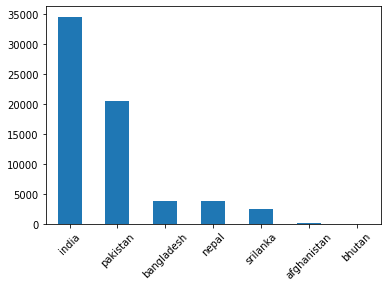

In [6]:
master_data['location'].value_counts().plot.bar(rot=45)

<AxesSubplot:>

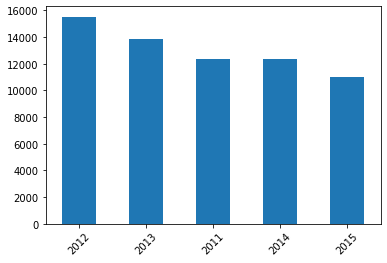

In [7]:
master_data['year'].value_counts().plot.bar(rot=45)

## Sample 3000 rows each year

In [10]:
relevant = master_data[master_data["Relevance"] == True]
grouped_df = relevant.groupby('year')
# for key, item in grouped_df:
#     print(grouped_df.get_group(key), "\n\n")

In [11]:
sample_df = relevant.groupby('year').apply(lambda x: x.sample(3000))
sample_df

year  month  location  \
year                                
2011 61704  2011      7  pakistan   
     57597  2011      9     india   
     57025  2011      8     india   
     54760  2011      4     india   
     53994  2011      2     india   
...          ...    ...       ...   
2015 3625   2015      6     india   
     8755   2015      8  pakistan   
     6061   2015     10     india   
     2769   2015      4     india   
     8152   2015      5  pakistan   

                                                         news  Relevance  
year                                                                      
2011 61704  The Inter Services Intelligence (ISI) official...       True  
     57597  Calling Naxalism (Left Wing Extremism) a bigge...       True  
     57025  The Indian Navy captured a hijacked Iranian fl...       True  
     54760  Times of India reports that Chichgarh squad of...       True  
     53994  Indian Express reports that the cadres of the ...       True  
...                                                       ...        ...  
2015 3625   Death toll rises to three as one more militant...       True  
     8755   Lahore High Court (LHC) issued a notice to the...       True  
     6061   As there was early snowfall along the Line of ...       True  
     2769   Chinar Corps General Officer Commanding (GOC) ...       True  
     8152   The United States (US) has handed over 14 comb...       True  

[15000 rows x 5 columns]

<AxesSubplot:>

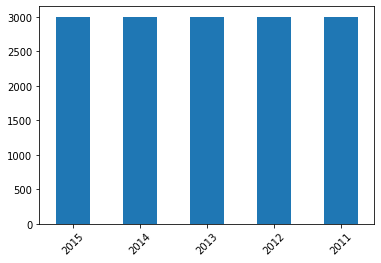

In [12]:
sample_df['year'].value_counts().plot.bar(rot=45)

<AxesSubplot:>

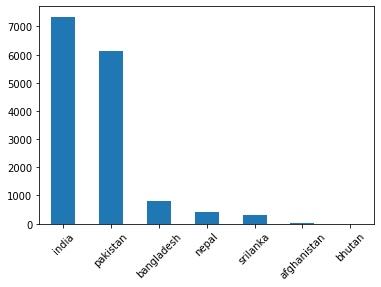

In [13]:
sample_df['location'].value_counts().plot.bar(rot=45)

In [14]:
print('Relevance:\n')
print(sample_df['Relevance'].value_counts())

Relevance:

True    15000
Name: Relevance, dtype: int64


## Sample 60% from each location (Total 9000)

In [15]:
sample_df = sample_df.groupby('location').apply(lambda x: x.sample(frac = 0.6))
sample_df

year  month     location  \
location    year                                   
afghanistan 2015 10529  2015      7  afghanistan   
                 10523  2015      3  afghanistan   
                 10527  2015      7  afghanistan   
                 10525  2015      3  afghanistan   
            2011 64582  2011      9  afghanistan   
...                      ...    ...          ...   
srilanka    2012 52294  2012      1     srilanka   
            2013 36942  2013      6     srilanka   
            2014 23277  2014     11     srilanka   
            2013 36829  2013      4     srilanka   
            2014 22849  2014      1     srilanka   

                                                                     news  \
location    year                                                            
afghanistan 2015 10529  Another senior Afghan Government official quot...   
                 10523  Tehreek e Taliban Pakistan (TTP) splinter grou...   
                 10527  Maulvi Shahidullah Shahid, a former Tehreek e ...   
                 10525  A US drone strike killed 11 Tehreek e Taliban ...   
            2011 64582  The NATO led International Security Assistance...   
...                                                                   ...   
srilanka    2012 52294  Cabinet Spokesman and Media Minister Keheliya ...   
            2013 36942  Meanwhile, President Mahinda Rajapaksa, addres...   
            2014 23277  Sri Lanka’s Permanent Representative to the Un...   
            2013 36829  A man engaged in de mining in Muhamalai of Jaf...   
            2014 22849  The 18th anniversary of the deadliest suicide ...   

                        Relevance  
location    year                   
afghanistan 2015 10529       True  
                 10523       True  
                 10527       True  
                 10525       True  
            2011 64582       True  
...                           ...  
srilanka    2012 52294       True  
            2013 36942       True  
            2014 23277       True  
            2013 36829       True  
            2014 22849       True  

[9000 rows x 5 columns]

In [16]:
print('Relevance:\n')
print(sample_df['Relevance'].value_counts())

Relevance:

True    9000
Name: Relevance, dtype: int64


<AxesSubplot:>

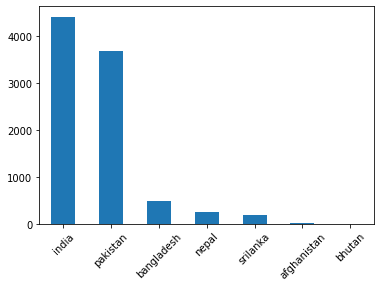

In [17]:
sample_df['location'].value_counts().plot.bar(rot=45)

In [ ]:
# sample_df.to_csv("Data_TagTog_NotAnnotated/sampled_9000_relevant_data.csv", header=True, index = False)

# 4. create_data_for_annotation

In [18]:
sample_df = pd.read_csv('Data_TagTog_NotAnnotated/sampled_9000_relevant_data.csv', header=[0])
sample_df.drop(columns=["Relevance"], inplace=True)

chunk_size = int(sample_df.shape[0] / 18)
i = 10
for start in range(0, sample_df.shape[0], chunk_size):
    df_subset = sample_df.iloc[start:start + chunk_size]
    filename = 'Data_TagTog_NotAnnotated/TagTog_Data/news_satp_%s.tsv'%i
    df_subset.to_csv(filename, index=False, header=True, sep='\t')
    i += 1
    print(filename, df_subset.shape)

Data_TagTog_NotAnnotated/TagTog_Data/news_satp_10.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_11.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_12.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_13.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_14.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_15.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_16.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_17.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_18.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_19.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_20.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_21.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_22.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_23.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_24.tsv (500, 5)
Data_TagTog_NotAnnotated/TagTog_Data/news_satp_25.tsv (

# 5. retrieve_data_from_tagtog

In [2]:
from io import StringIO
from pandarallel import pandarallel

tagtogAPIUrl = "https://www.tagtog.net/-api/documents/v1"
USERNAME = 'ssp180002'
PASSWORD = '1234567'

In [3]:
def get_doc_id(url = tagtogAPIUrl, project = None, folder = None):
    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)
    params = {'project':project, 'owner': USERNAME, 'search':folder, 'page':'1', 'output':'csv'}
    response = requests.get(url, params=params, auth=auth)
    content = response.text.split('\n')
    return [i.split(',')[0] for i in content]

def get_data(ids, url=tagtogAPIUrl, project = None,folder = None):
 
    # Get entities
    
    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)
    params = {'project': project, 'owner': USERNAME, 'search': folder, 'page': '1',
              'output': 'entitiestsv','ids': ids}

    entitiestsv = requests.get(url, params=params, auth=auth)
    
    stringIO = StringIO(entitiestsv.text)
    df = pd.read_csv(stringIO , sep="\t", names = ['text','annotated'])

    index, year, month, country = df.text[1], df.text[3], df.text[5], df.text[7]
    news = df.text[9:].str.cat().encode("ascii", "ignore").decode()

    target = df[df.annotated == 'Target-1']['text'].tolist()
    source = df[df.annotated == 'Source-1']['text'].tolist()
    action = df[df.annotated == 'Action-1']['text'].tolist()
    location = df[df.annotated == 'Location-1']['text'].tolist()
    date = df[df.annotated == 'Date-1']['text'].tolist()
    
       
    # Get is_relevant and action_type
    
    auth = requests.auth.HTTPBasicAuth(username=USERNAME, password=PASSWORD)
    params = {'project': project, 'owner': USERNAME, 'search': 'folder:pool', 'page': '1',
              'output': 'ann.json','ids': ids}
    response = requests.get(url, params=params, auth=auth)
    json_data = response.json()

    
    # if no labels or not confirmed, return None
    if 'm_1' not in json_data['metas']:
        print('No labels', index)
        return
    else:
        is_relevant =  json_data['metas']['m_1']['value']

    if json_data['anncomplete'] == False:
        print('Not confirmed', index)
        return
    

    action_type = None
    if json_data['entities']:
        df2 = pd.json_normalize(json_data['entities'])
        if  'fields.f_17.value' in df2.columns:
            df2 = df2[['fields.f_17.value']].rename(columns={"fields.f_17.value": "action_type"})
            df2 = df2.dropna()
            if len(df2)==0:
                action_type = "NotSpecified"
            else: 
                action_type = df2.action_type.tolist()
    

    return [ids, index, is_relevant, target,	source,	action,	action_type, location,	date, country,	year,	news]

## Parallelly retrieve annotations

<big> Now we can retrieve annotations from folder p1 to the latest p15. Here I only show the process of getting p2-p15 because p1 use a different group of keys.  Let's ignore p1 but just use the original file by Shahreen.</big>

In [4]:
pandarallel.initialize()

for i in range(15,16):
    p = 'p%s'%i
    print('\n----- %s -----\n'%p)
    project_list = ['demo', 'satp_news_data_500_'+ p]
    folder_list = ['folder:pool/Practice', 'folder:pool']
    
    # Get item ids from the TagTog API
    doc_id = get_doc_id(tagtogAPIUrl, project_list[1], folder_list[1])
    # ignore the first row (header) and the final row (null)
    doc_id = doc_id[1:-1] 
    

    s = pd.Series(doc_id).parallel_apply(get_data, args = (tagtogAPIUrl, project_list[1], folder_list[1])).dropna()
    df_all = pd.DataFrame(item for item in s)
    df_all.columns = ['id','index','is_relevant', 'target', 'source', 'action', 'action_type' , 'location', 'date','country', 'year', 'news']
    
#     df_all.to_csv('Data_TagTog_Annotated/'+ p +'.csv', header=True, index=False)

INFO: Pandarallel will run on 36 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

----- p15 -----



## Concatenation of all the annotations

In [5]:
df_list=[]
for i in range(1,16):
    p = 'p%s'%i
    print('%s'%p, end = ' ')
    df = pd.read_csv('Data_TagTog_Annotated/'+ p +'.csv', header=[0]) 
    df_list.append(df)

p1 p2 p3 p4 p5 p6 p7 p8 p9 p10 p11 p12 p13 p14 p15 

In [6]:
df_total = pd.concat(df_list).reset_index(drop=True)
df_total

,id,is_relevant,target,source,action,action_type,location,date,country,year,news,index
0,32355,True,"['Rangers', 'Rangers', 'Military Police']","['Lashkar e Jhangvi LeJ', 'militants', 'milita...","['killing', 'killed', 'gunned']","['Armed Assault', 'Armed Assault', 'Armed Assa...",['Karachi'],['December 6'],pakistan,2016,Two Lashkar e Jhangvi LeJ militants Asim alias...,NaN
1,32398,True,"['Security Forces', 'SFs', 'civilians']",NaN,"['killed', 'fighting', 'wounded', 'fighting', ...","['Unknown', 'Unknown', 'Unknown', 'Unknown', '...",NaN,['December 20'],pakistan,2016,The Commander Southern Command Lieutenant Gene...,NaN
2,29171,True,"['Naga', 'Naga', 'Nagas', 'Naga']","['Manipur Naga Peopleâ€™s Front', 'MNPF', 'MNP...","['explosion', 'exploded', 'bomb', 'attack']","['Bombing/Explosion', 'Bombing/Explosion', 'Bo...",NaN,['August 30'],india,2016,Meanwhile the underground organization Manipur...,NaN
3,25445,True,"['Artisan Restaurant', 'foreigners', 'hostages']","['attackers', 'suicide fighters', 'suicide sol...","['gun battle', 'killing', 'injuring']","['Armed Assault', 'Armed Assault', 'Armed Assa...",['Dhaka'],"['August', '27th']",bangladesh,2016,Islamic State IS in the latest issue of its on...,NaN
4,31739,True,"['Muttahida Qaumi Movement', 'MQM', 'MQM']",NaN,['shot'],['Assassination'],"['Naeemabad', 'Korangi', 'Karachi', 'Sindh']",['June 19'],pakistan,2016,A senior Muttahida Qaumi Movement MQM worker i...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7485,10483,False,[],[],[],NaN,[],[],nepal,2015,Clashes between demonstrators and Police leave...,a9qjjlMsQqy8XtuhYUJ6QMLlDz88-news_satp_15.tsv_46
7486,42333,False,[],[],[],NaN,[],[],india,2012,The death toll in the ongoing clashes between ...,a6U4BlcbFbLRZKmdIMjCcxSEV7ni-news_satp_15.tsv_35
7487,21314,False,[],[],[],NaN,[],[],pakistan,2014,An unnamed security official revealed that Fro...,aBikefqUY7LvQEJe5Sn96IE92aEK-news_satp_15.tsv_39
7488,58183,True,"['Police', 'Police']",['militants'],"['grenade', 'grenade', 'exploded']","['Bombing/Explosion', 'Bombing/Explosion', 'Bo...",['Srinagar'],['October 16'],india,2011,Police said that militants hurled a grenade on...,a8iR07wYXkm9CV3iPTxqGE4CaaMC-news_satp_15.tsv_52


 ## Running Performances

<ipython-input-7-09c4084b8dd4>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list, width=0.5)


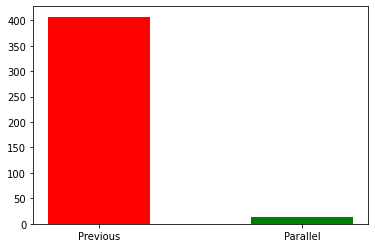

In [7]:
import matplotlib.pyplot as plt

name_list = ['Previous','Parallel']
num_list = [407,13]
plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list, width=0.5)
plt.show()